# Loading Libraries

In [281]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
import scipy.stats as stats
import math

#for data visualization
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import copy
import sys
# set_matplotlib_formats('svg')

# Using GPU

In [282]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Checking waveforms

In [283]:
un_normalized_data = np.load('data/wavenumbers.npy')      #(1000)       #y()
X_ref = np.load('data/X_reference.npy')      #(60000,1000) #y(60000)
orig_data = un_normalized_data.mean() + X_ref*un_normalized_data.std()

max = 0
min = 100000
for data in orig_data:
    if np.max(data) > max:
        max = np.max(data)
    elif np.min(data) < min:
        min = np.min(data)
print(f'data max = {max}')
print(f'data min = {min}')
print(f'length = {len(orig_data)}')

print(f'data before norm max = {np.max(un_normalized_data)}')
print(f'data before norm min = {np.min(un_normalized_data)}')


data max = 1517.514882774068
data min = 1110.19469
length = 60000
data before norm max = 1792.4
data before norm min = 381.98


# Loading Reference & Test Data

In [284]:
# Train: Load input features Train Data
X_ref = np.load('data/X_reference.npy')      #(60000,1000) #y(60000)
train_waveforms = X_ref.reshape(X_ref.shape[0], 1, X_ref.shape[1])

# Train: Load output target labels Train Data
train_labels = np.load('data/y_reference.npy')      #(60000,1000) #y(60000)

# Test: Load Test Data
test_waveforms = np.load('data/X_test.npy')           #(3000, 1000) #y(3000)
test_waveforms = test_waveforms.reshape(test_waveforms.shape[0], 1, test_waveforms.shape[1])

# Test: Load output target labels Test Data
test_labels = np.load('data/y_test.npy')           #(3000, 1000) #y(3000)

In [285]:
# Check number of output target labels

print(f'train labels [{np.min(train_labels):0.0f},{np.max(train_labels):0.0f}]')
print(f'test  labels [{np.min(test_labels):0.0f},{np.max(test_labels):0.0f}]')

train labels [0,29]
test  labels [0,29]


# Convert Train & Test into tensors, Datasets & DataLoader

In [286]:
# Convert Train & Test Into Tensor

train_waveforms = torch.tensor(train_waveforms).float()
test_waveforms  = torch.tensor(test_waveforms).float()
train_labels    = torch.tensor(train_labels).long()
test_labels     = torch.tensor(test_labels).long()

In [287]:
# check if sizes are correct

print(f'#### train data ####\
    \ntrain_waveforms = {train_waveforms.shape} \
    \ntrain_labels = {train_labels.shape}\
    \n#### test data #### \
    \ntest_waveforms = {test_waveforms.shape} \
    \ntest_labels = {test_labels.shape}\
    ')

#### train data ####    
train_waveforms = torch.Size([60000, 1, 1000])     
train_labels = torch.Size([60000])    
#### test data ####     
test_waveforms = torch.Size([3000, 1, 1000])     
test_labels = torch.Size([3000])    


In [288]:
# Convert into Dataset

train_dataset = TensorDataset(train_waveforms, train_labels)
test_dataset  = TensorDataset(test_waveforms, test_labels)

In [289]:
# Split the Train dataset into Train dataset & Validation dataset

randidx         = np.random.permutation(60000)
dev_indices     = randidx[:6000]
train_indices   = randidx[6000:]
dev_dataset     = Subset(train_dataset, dev_indices)
train_dataset   = Subset(train_dataset, train_indices)

In [290]:
# Translate into dataloader objects

batchsize       = 64
train_loader    = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
dev_loader      = DataLoader(dev_dataset,   batch_size=batchsize, shuffle=True, drop_last=True)
test_loader     = DataLoader(test_dataset,  batch_size=batchsize, shuffle=True)

In [291]:
test_dataset.tensors[0].shape[2]

1000

In [292]:
X, y = next(iter(train_loader))
print(X.data.shape)

torch.Size([64, 1, 1000])


In [293]:
X, y = next(iter(dev_loader))
print(X.data.shape)

torch.Size([64, 1, 1000])


In [294]:
X, y = next(iter(test_loader))
print(X.data.shape)

torch.Size([64, 1, 1000])


# ViT Function

In [295]:
from transformers import ViTConfig, ViTModel
from transformers import ViTForImageClassification
from transformers import AutoImageProcessor, ViTImageProcessor

In [306]:
# Create the Deep Learning Model
def createTheNet(printtoggle=False):
    class ViT1D(nn.Module):
        def __init__(self, 
                     sequence_length=1000, 
                     patch_size=50, 
                     d_model=200, 
                     num_heads=4, 
                     num_layers=4, 
                     num_classes=30, 
                     dropout=0.2):
            super(ViT1D, self).__init__()
            
            # Number of patches
            self.num_patches = sequence_length // patch_size
            self.patch_size = patch_size
            
            # CLS token (trainable)
            # self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

            # Patch embedding layer
            self.patch_embedding = nn.Linear(patch_size, d_model)
            
            # Positional embedding
            self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches, d_model))
            # self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, d_model))
            
            # Transformer encoder layers
            encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            
            # Classification head
            self.fc = nn.Sequential(
                nn.LayerNorm(d_model),  # Layer normalization before final classification
                nn.Linear(d_model, 100),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(100, num_classes)
            )

        def forward(self, x):
            # Remove the channel dimension as it's 1, so we only need batch_size and sequence_length
            x = x.squeeze(1)  # Shape [batch_size, 1000]

            # Break input into patches
            x = x.unfold(1, self.patch_size, self.patch_size)  # Shape [batch_size, num_patches, patch_size]
            
            # Patch embedding
            x = self.patch_embedding(x)
            
            # Add CLS token to the batch
            # batch_size = x.shape[0]
            # cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # Shape [batch_size, 1, d_model]
            # x = torch.cat((cls_tokens, x), dim=1)  # Concatenate CLS token

            # Add positional embedding
            x = x + self.position_embedding
            
            # Apply transformer encoder
            x = self.transformer_encoder(x)
            
            # # Global average pooling
            x = x.mean(dim=1)
            
            # # Take the CLS token's output for classification
            # cls_output = x[:, 0]  # Shape [batch_size, d_model]

            # Classification head
            x = self.fc(x)
            
            return x

        
    modelInstance = ViT1D(sequence_length=1000, 
                          patch_size=50, 
                          d_model=256, 
                          num_heads=4, 
                          num_layers=3, 
                          num_classes=30,
                          dropout=0.25
                          ).to(device)
    
    lossfun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.AdamW(modelInstance.parameters(), lr=1e-4)#, weight_decay=1e-4)
                                #,betas=(0.5, 0.999), eps=1e-8)
    #, betas=(0.9, 0.999), eps=1e-8)
    
    return modelInstance, lossfun, optimizer

# Testing ViT with random data

In [307]:
#Test with 1 batch
net2, lossfun2, optimizer2 = createTheNet(True)

# X, y = next(iter(train_loader))
for X, y in train_loader:

    X = X.to(device)
    y = y.to(device)

    print("y shape", y.shape)
    print(y)

    yHat = net2(X)
    print("yHat shape", yHat.shape)
    print(yHat)

    #compute the loss
    loss = lossfun2(yHat, y)
    print(loss)
    
    break

c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


y shape torch.Size([64])
tensor([16,  1, 21, 23,  8,  8, 24,  8, 25,  6,  9, 27, 28, 24,  4,  6,  6, 17,
        29,  6, 28, 27, 25,  8, 11,  6,  8, 16,  1, 28, 21,  9,  0, 23,  4, 10,
        23, 23,  2,  7,  3, 13, 20,  1,  2, 20, 23,  9, 12, 19,  4, 11, 12, 15,
        24,  4, 13, 11, 15,  5, 10, 12, 17, 14], device='cuda:0')
yHat shape torch.Size([64, 30])
tensor([[ 0.4826,  0.0649, -0.6434,  ..., -0.2164,  0.3220,  0.1420],
        [ 0.3270,  0.1622, -0.4075,  ...,  0.1335, -0.1038, -0.2994],
        [ 0.3458,  0.3845, -0.6928,  ..., -0.0083, -0.3617, -0.1013],
        ...,
        [ 0.8221, -0.1086, -0.5794,  ...,  0.1465,  0.1032, -0.2599],
        [ 0.6242, -0.0292, -0.5767,  ..., -0.2661, -0.0317, -0.3049],
        [ 0.8254, -0.0755, -0.5863,  ..., -0.1534,  0.4650, -0.2804]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(3.4135, device='cuda:0', grad_fn=<NllLossBackward0>)


# Training Function

In [308]:
# Train the Model

def trainTheModel(trainedModel, lossfun, optimizer, epochs=10):
    
    #number of epochs to train
    numepochs = epochs
    trainedModel.train()
        
    #initialize losses & accuracy
    trainLoss   = torch.zeros(numepochs)
    trainAcc = []
    testLoss   = torch.zeros(numepochs)
    testAcc  = []
    valLoss   = torch.zeros(numepochs)
    valAcc  = []

    for epochi in range(numepochs):
        
        #batch loss & accuracy
        trainBatchLoss = []
        trainBatchAcc  = []
        
        #loop over mini-batches
        for X,y in train_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)
            
            #Forward pass & loss
            yHat = trainedModel(X)
            loss = lossfun(yHat, y)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #loss from this batch
            trainBatchLoss.append(loss.item())
            
            #accuracy from this batch -> for BCE sigmoid
            # trainMatches = torch.sigmoid(yHat) > 0.9 ##
            # trainMatchesNumeric = trainMatches.float()
            # trainBatchAcc.append( torch.mean( (trainMatchesNumeric == y.float()).float() ).item() )

            # batchMathces = (torch.abs(yHat - y)).detach().cpu().float().numpy()
            # batchAcc.append(( batchMathces < 0.5))
            
            # accuracy from this batch for categorical data cross entropy loss
            accMatches = torch.argmax(yHat, axis=1)
            accMatchesNumeric = (accMatches == y).float()
            trainBatchAcc.append( torch.mean(accMatchesNumeric).item() )
        
        #average accuracy across mini-batches
        trainAcc.append(100 * np.mean((trainBatchAcc)))
        
        #average losses across all mini-batches
        trainLoss[epochi] = np.mean(trainBatchLoss)
        
        ################################
        # eval mode
        # do not use dropout 
        # do not use batch normalization instead use avg
        trainedModel.eval()
        ################################
        # X,y = next(iter(test_loader))

        # X = X.to(device)
        # y = y.to(device)

        # #forward pass & loss
        # with torch.no_grad():
        #     yHat = trainedModel(X)
        #     loss = lossfun(yHat, y)
            
        # testLoss = loss.item()
            
        # testAccMatches = torch.argmax(yHat, axis=1)
        # testAccMatchesNumeric = (testAccMatches == y).float()
        # testAcc = ( 100 * torch.mean(testAccMatchesNumeric) ).item()
        # print("testAcc",testAcc)
        ################################
        #batch loss & accuracy
        testBatchLoss = []
        testBatchAcc  = []

        for X, y in test_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            #forward pass & loss
            with torch.no_grad():
                yHat = trainedModel(X)
                loss = lossfun(yHat, y)
            
            #batch loss    
            testBatchLoss.append(loss.item())
            
            #batch acc cross entropy
            accMatches = torch.argmax(yHat, axis=1)
            accMatchesNumeric = (accMatches == y).float()
            testBatchAcc.append( torch.mean(accMatchesNumeric).item() )

        #compute the test accuracy for categorical data
        testAcc.append(100*np.mean(testBatchAcc))
        
        testLoss[epochi] = ( np.mean(testBatchLoss) )
        
        ################################
        ################################
        ################################
        
        #batch loss & accuracy
        valBatchLoss = []
        valBatchAcc  = []

        for X, y in dev_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            #forward pass & loss
            with torch.no_grad():
                yHat = trainedModel(X)
                loss = lossfun(yHat, y)
            
            #batch loss    
            valBatchLoss.append(loss.item())
            
            #batch acc cross entropy
            accMatches = torch.argmax(yHat, axis=1)
            accMatchesNumeric = (accMatches == y).float()
            valBatchAcc.append( torch.mean(accMatchesNumeric).item() )

        #compute the test accuracy for categorical data
        valAcc.append(100*np.mean(valBatchAcc))
        
        valLoss[epochi] = ( np.mean(valBatchLoss) )

        msg1 = f'Epoch = {epochi+1}/{epochs}, # '
        msg2 = f'TrainAcc = {trainAcc[-1]:0.2f}, # '
        msg3 = f'ValAcc   = {valAcc[-1]:0.2f} # '
        msg4 = f'TestAcc  = {testAcc[-1]:0.2f}'
        sys.stdout.write('\r' + msg1 + msg2 + msg3 + msg4)

    return trainAcc, trainLoss, testAcc, testLoss, valAcc, valLoss, trainedModel

# Testing Training

In [309]:
# # Test the training code that it has NO ERRORS
# epochs=1
# myModelInstance2, lossfun2, optimizer2 = createTheNet()
# # losses2, trainedModel2 = trainTheModel(myModelInstance2, lossfun, optimizer, epochs)
# # trainAcc2, losses2, trainedModel2 = trainTheModel(myModelInstance2, lossfun, optimizer, epochs)
# trainAcc2, trainLoss2, testAcc2, testLoss2, trainedModel2 = trainTheModel(myModelInstance2, lossfun2, optimizer2, epochs)

In [310]:
# X, y = next(iter(train_loader))
# X = X.to(device)
# y = y.to(device)
# yHat = trainedModel2(X)

# Actual Training

In [311]:
# Train the Model
epochs=15
myModelInstance, lossfun, optimizer = createTheNet()
trainAcc, trainLoss, testAcc, testLoss, valAcc, valLoss, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer, epochs)

Epoch = 15/15, # TrainAcc = 91.95, # ValAcc   = 89.18 # TestAcc  = 52.03

In [167]:
# X, y = next(iter(train_loader))
# X = X.to(device)
# y = y.to(device)
# yHat = trainedModel(X)
# print("yHat = ",yHat)
# print("y    = ",y)

In [168]:
# testAcc

# Plotting Loss & Accuracy for reference dataset

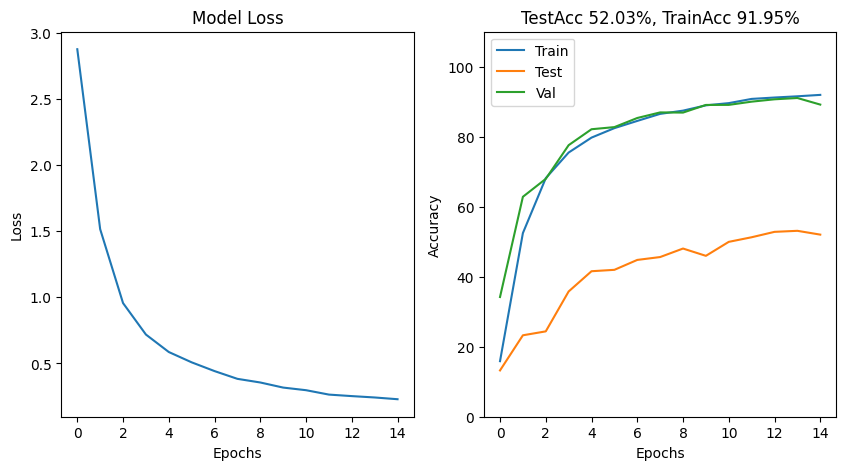

In [312]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(trainLoss, label='Train')
# ax[0].plot(testLoss, label='Dev')
# ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
# ax[0].set_xlim([0,10])

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].plot(valAcc, label='Val')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'TestAcc {testAcc[-1]:.2f}%, TrainAcc {trainAcc[-1]:.2f}%')
ax[1].set_ylim([0,110])
# ax[1].set_xlim([0,5])

plt.show()

# Finetuning Training with X_Finetune

In [ ]:
# fine-tuning with finetune dataset
# train_waveforms = np.load('data/X_2018clinical.npy')   #(10000,1000) #y(10000)
# train_waveforms = np.load('data/X_2019clinical.npy')   #(2500, 1000) #y(2500)
# train_labels = np.load('data/y_2018clinical.npy')   #(10000,1000) #y(10000)
# train_labels = np.load('data/y_2019clinical.npy')   #(2500, 1000) #y(2500)

X_ref = np.load('data/X_finetune.npy')       #(3000, 1000) #y(1000)
##
train_waveforms = X_ref.reshape(X_ref.shape[0], 1, X_ref.shape[1])
train_waveforms = torch.tensor(train_waveforms).float()
##
test_waveforms = np.load('data/X_test.npy')           #(3000, 1000) #y(3000)
test_waveforms = test_waveforms.reshape(test_waveforms.shape[0], 1, test_waveforms.shape[1])
test_waveforms = torch.tensor(test_waveforms).float()
##
train_labels = np.load('data/y_finetune.npy')       #(3000, 1000) #y(1000)
train_labels = torch.tensor(train_labels).long()
##
test_labels = np.load('data/y_test.npy')           #(3000, 1000) #y(3000)
test_labels = torch.tensor(test_labels).long()
##
train_dataset = TensorDataset(train_waveforms, train_labels)
test_dataset  = TensorDataset(test_waveforms, test_labels)

# Step 3: Split the testset into test & dev
randidx         = np.random.permutation(3000)
dev_indices     = randidx[:300]
train_indices   = randidx[300:]
dev_dataset     = Subset(train_dataset, dev_indices)
train_dataset   = Subset(train_dataset, train_indices)

# Step 4: Translate into dataloader objects
batchsize    = 64
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=True)

epochs = 30
trainAcc, trainLoss, testAcc, testLoss, valAcc, valLoss, finetunedModel = trainTheModel(trainedModel, lossfun, optimizer, epochs)


Epoch = 3/30, # TrainAcc = 95.05, # ValAcc   = 93.36 # TestAcc  = 80.17

# FineTuning Bacteria Accuracy & Loss Plot

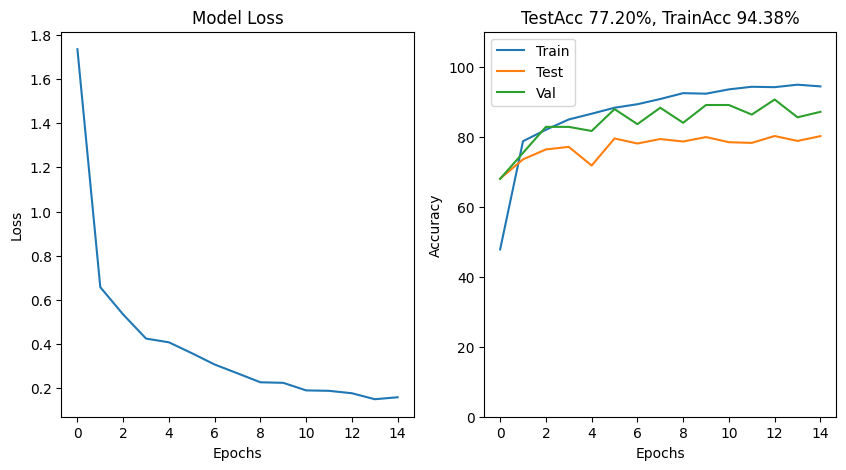

In [314]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(trainLoss, label='Train')
# ax[0].plot(testLoss, label='Dev')
# ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
# ax[0].set_xlim([0,10])

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].plot(valAcc, label='Val')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'TestAcc {np.mean(testAcc):.2f}%, TrainAcc {trainAcc[-1]:.2f}%')
ax[1].set_ylim([0,110])
# ax[1].set_xlim([0,5])

plt.show()

In [83]:
# bacteria_confusion = { 
#      0 :"MRSA 1 (isogenic)" #16
#     ,1 :"MRSA 2"            #17
#     ,2 :"MSSA 1"            #14
#     ,3 :"MSSA 2"            #18
#     ,4 :"MSSA 3"            #15
#     ,5 :"S. epidermidis"    #20
#     ,6 :"S. lugdunensis"    #21
#     ,7 :"S. pneumoniae 1"   #23 => order 24 in paper
#     ,8 :"S. pneumoniae 2"   #24 => order 23 in paper
#     ,9 :"Group A Strep."    #26
#     ,10:"Group B Strep."    #27
#     ,11:"Group C Strep."    #28
#     ,12:"Group G Strep."    #29
#     ,13:"S. sanguinis"      #25
#     ,14:"E. faecalis 1"     #6
#     ,15:"E. faecalis 2"     #7
#     ,16:"E. faecium"        #5
#     ,17:"E. coli 1"         #3
#     ,18:"E. coli 2"         #4
#     ,19:"K. pneumoniae 1"   #9
#     ,20:"K. pneumoniae 2"   #10
#     ,21:"K. aerogenes"      #2
#     ,22:"E. cloacae"        #8
#     ,23:"P. mirabilis"      #11
#     ,24:"S. marcescens"     #22
#     ,25:"S. enterica"       #19
#     ,26:"P. aeruginosa 1"   #12
#     ,27:"P. aeruginosa 2"   #13
#     ,28:"C. albicans"       #0
#     ,29:"C. glabrata"       #1
# }

# Lists & Dictionaries for the bacterial output labels 
# and their corresponding antibiotic

In [84]:
ORDER = [16, 17, 14, 18, 15, 20, 21, 23, 24, 26, 27, 28, 29, 25, 6, 7, 5, 3, 4,
         9, 10, 2, 8, 11, 22, 19, 12, 13, 0, 1]

# strain
bacteria_dataset = { 
     0 :"C. albicans"
    ,1 :"C. glabrata"
    ,2 :"K. aerogenes"
    ,3 :"E. coli 1"
    ,4 :"E. coli 2"
    ,5 :"E. faecium"
    ,6 :"E. faecalis 1"
    ,7 :"E. faecalis 2"
    ,8 :"E. cloacae"
    ,9:"K. pneumoniae 1"
    ,10:"K. pneumoniae 2"
    ,11:"P. mirabilis"
    ,12:"P. aeruginosa 1"
    ,13:"P. aeruginosa 2"
    ,14:"MSSA 1"
    ,15:"MSSA 3"
    ,16:"MRSA 1 (isogenic)"
    ,17:"MRSA 2"
    ,18:"MSSA 2"
    ,19:"S. enterica"
    ,20:"S. epidermidis"
    ,21:"S. lugdunensis"
    ,22:"S. marcescens"
    ,23:"S. pneumoniae 1"
    ,24:"S. pneumoniae 2"
    ,25:"S. sanguinis"
    ,26:"Group A Strep."
    ,27:"Group B Strep."
    ,28:"Group C Strep."
    ,29:"Group G Strep."
}

In [85]:


bacteria_confusion = { 
    "MRSA 1 (isogenic)"		:0 ,	#16
    "MRSA 2"            	:1 ,	#17
    "MSSA 1"            	:2 ,	#14
    "MSSA 2"            	:3 ,	#18
    "MSSA 3"            	:4 ,	#15
    "S. epidermidis"    	:5 ,	#20
    "S. lugdunensis"    	:6 ,	#21
    "S. pneumoniae 1"   	:7 ,	#23 => order 24 in paper
    "S. pneumoniae 2"   	:8 ,	#24 => order 23 in paper
    "Group A Strep."    	:9 ,	#26
    "Group B Strep."    	:10,	#27
    "Group C Strep."    	:11,	#28
    "Group G Strep."    	:12,	#29
    "S. sanguinis"      	:13,	#25
    "E. faecalis 1"     	:14,	#6
    "E. faecalis 2"     	:15,	#7
    "E. faecium"        	:16,	#5
    "E. coli 1"         	:17,	#3
    "E. coli 2"         	:18,	#4
    "K. pneumoniae 1"   	:19,	#9
    "K. pneumoniae 2"   	:20,	#10
    "K. aerogenes"      	:21,	#2
    "E. cloacae"        	:22,	#8
    "P. mirabilis"      	:23,	#11
    "S. marcescens"     	:24,	#22
    "S. enterica"       	:25,	#19
    "P. aeruginosa 1"   	:26,	#12
    "P. aeruginosa 2"   	:27,	#13
    "C. albicans"       	:28,	#0
    "C. glabrata"       	:29,	#1
}                       	   

# Confusion Matrix for Acutal Bacteria 
# vs Predicted Bacteria

In [86]:
test_loader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=True)

for X, y in test_loader:

    X = X.to(device)
    y = y.to(device)
    finetunedModel.eval()
    
    yHat = finetunedModel(X)
    
y       = y.detach().cpu().numpy()
yHat    = yHat.detach().cpu().numpy()
yHat_labels = np.argmax(yHat, axis=1)
print(f'y    shape = {y.shape}')
print(f'yHat shape = {yHat_labels.shape}')

sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})

label = [bacteria_dataset[i] for i in ORDER]


cm = confusion_matrix(y, yHat_labels, labels=ORDER)
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]

plt.figure(figsize=(15, 12))
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='1.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.29 GiB. GPU 0 has a total capacty of 6.00 GiB of which 0 bytes is free. Of the allocated memory 18.43 GiB is allocated by PyTorch, and 1.43 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [31]:

ATCC_GROUPINGS = {3: 0,
                  4: 0,
                  9: 0,
                  10: 0,
                  2: 0,
                  8: 0,
                  11: 0,
                  22: 0,
                  12: 2,
                  13: 2,
                  14: 3, # MSSA
                  18: 3, # MSSA
                  15: 3, # MSSA
                  20: 3,
                  21: 3,
                  16: 3, # isogenic MRSA
                  17: 3, # MRSA
                  23: 4,
                  24: 4,
                  26: 5,
                  27: 5,
                  28: 5,
                  29: 5,
                  25: 5,
                  6: 5,
                  7: 5,
                  5: 6,
                  19: 1,
                  0: 7,
                  1: 7}

#group 3 is the 1st => Vancomycin
ab_order = [3, 4, 5, 6, 0, 1, 2, 7]

antibiotics = {}
antibiotics[0] = "Meropenem" # E. coli
antibiotics[1] = "Ciprofloxacin" # Salmonella
antibiotics[2] = "TZP" # PSA
antibiotics[3] = "Vancomycin" # Staph
antibiotics[4] = "Ceftriaxone" # Strep pneumo
antibiotics[5] = "Penicillin" # Strep + E. faecalis
antibiotics[6] = "Daptomycin" # E. faecium
antibiotics[7] = "Caspofungin" # Candidas



# Confusion matrix after conversion of predicted bacteria into Antibiotic groups

Accuracy: 96.5%


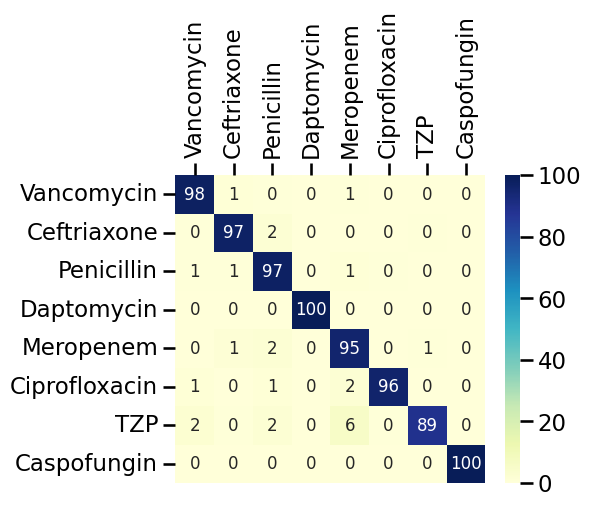

In [32]:
import time
test_loader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=True)

for X, y in test_loader:

    X = X.to(device)
    y = y.to(device)
    finetunedModel.eval()
    
    yHat = finetunedModel(X)
    
y       = y.detach().cpu().numpy()
yHat    = yHat.detach().cpu().numpy()
yHat_labels = np.argmax(yHat, axis=1)

# Mapping predictions into antibiotic groupings
y_ab = np.asarray([ATCC_GROUPINGS[i] for i in y])
y_ab_hat = np.asarray([ATCC_GROUPINGS[i] for i in yHat_labels])

# Computing accuracy
acc = (y_ab_hat == y_ab).mean()
print('Accuracy: {:0.1f}%'.format(100*acc))


sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [antibiotics[i] for i in ab_order]
cm = confusion_matrix(y_ab, y_ab_hat, labels=ab_order)
plt.figure(figsize=(5, 4))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()

# Reserved Code
# Fine-Tuning with 2018 Clinical Data

X min =  0.0
X max =  1.0
y min =  0.0
y max =  6.0
1000
9000
y    shape = (10,)
y          = [5 3 3 0 2 5 2 6 2 6]
yHat shape = (10,)
yHat       = [19 14 16 22  2 19 19 19 12  5]


C:\Users\elmog\AppData\Local\Temp\ipykernel_11992\2070320102.py:65: RuntimeWarning: invalid value encountered in divide
  cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]


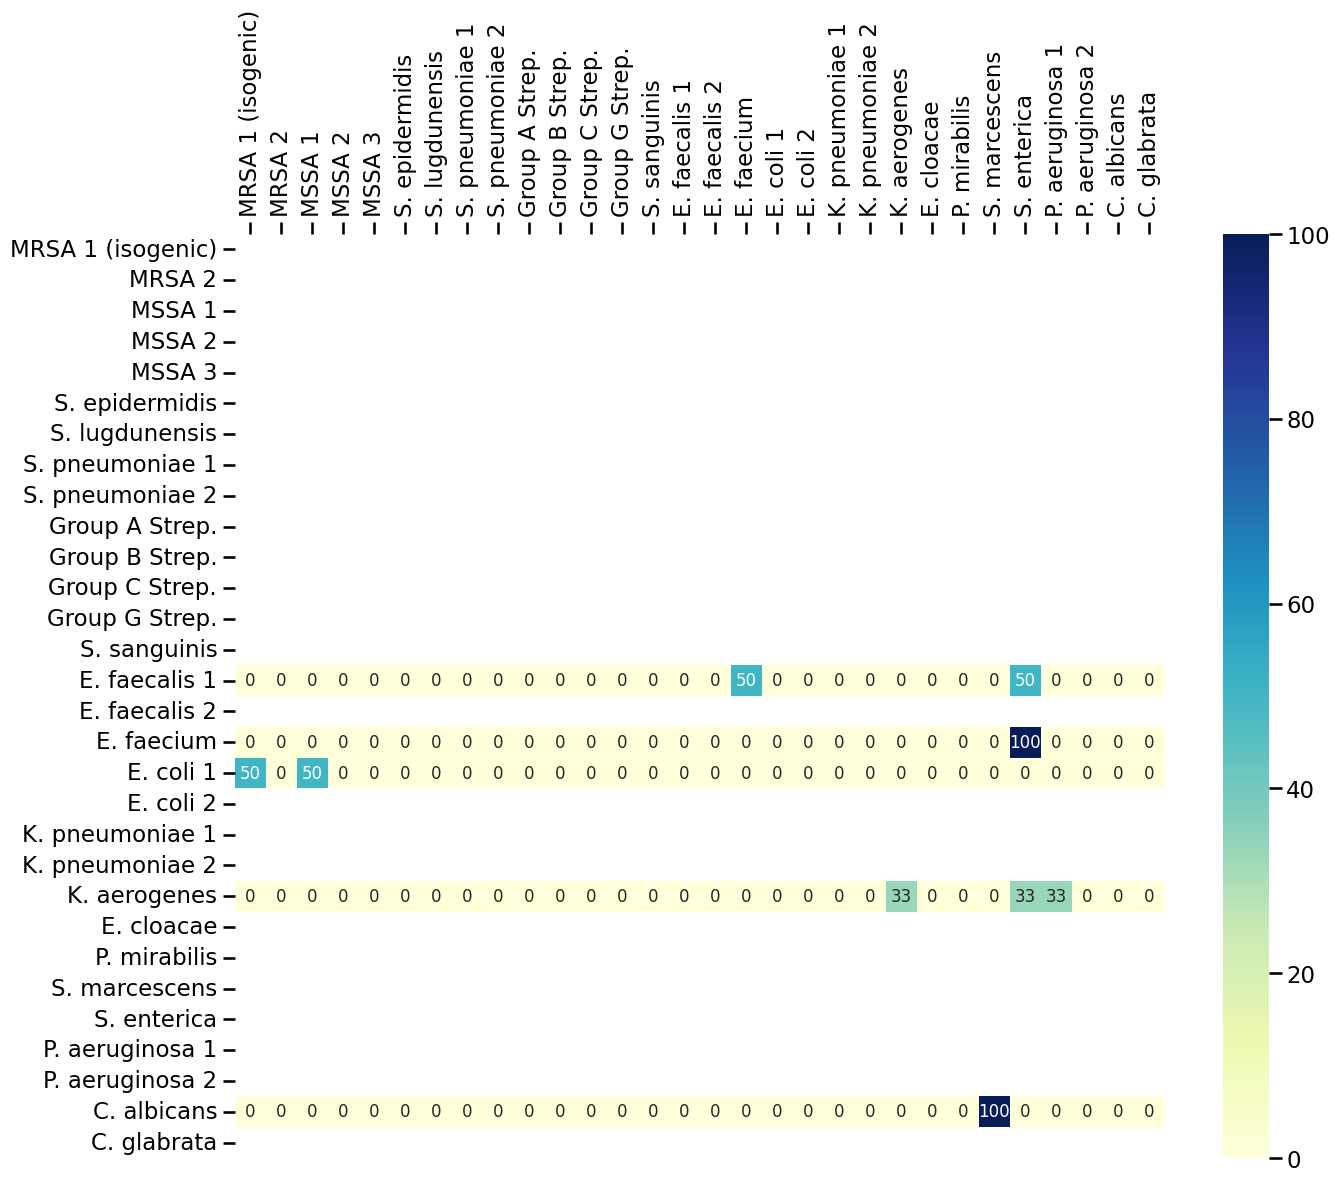

In [33]:
X_ref = np.load('data/X_2018clinical.npy')       #(10000,1000) #y(10000)
print('X min = ',np.min(X_ref))
print('X max = ',np.max(X_ref))
X_ref = np.load('data/y_2018clinical.npy')       #(10000,1000) #y(10000)
print('y min = ',np.min(X_ref))
print('y max = ',np.max(X_ref))

# fine-tuning with finetune dataset

X_ref = np.load('data/X_2018clinical.npy')       #(10000,1000) #y(10000)
##
train_waveforms = X_ref.reshape(X_ref.shape[0], 1, X_ref.shape[1])
train_waveforms = torch.tensor(train_waveforms).float()
##
test_waveforms = np.load('data/X_test.npy')           #(3000, 1000) #y(3000)
test_waveforms = test_waveforms.reshape(test_waveforms.shape[0], 1, test_waveforms.shape[1])
test_waveforms = torch.tensor(test_waveforms).float()
##
train_labels = np.load('data/y_2018clinical.npy')       #(10000,1000) #y(10000)
train_labels = torch.tensor(train_labels).long()
##
test_labels = np.load('data/y_test.npy')           #(3000, 1000) #y(3000)
test_labels = torch.tensor(test_labels).long()
##
train_dataset = TensorDataset(train_waveforms, train_labels)
test_dataset  = TensorDataset(test_waveforms, test_labels)

# Step 3: Split the testset into test & dev
randidx         = np.random.permutation(10000)
dev_indices     = randidx[:1000]
train_indices   = randidx[1000:]
dev_dataset     = Subset(train_dataset, dev_indices)
train_dataset   = Subset(train_dataset, train_indices)

print(len(dev_indices))
print(len(train_indices))
# # Step 4: Translate into dataloader objects
batchsize    = 64
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=True)

for X, y in train_loader:

    X = X.to(device)
    y = y.to(device)
    finetunedModel.eval()
    
    yHat = finetunedModel(X)

y       = y.detach().cpu().numpy()
yHat    = yHat.detach().cpu().numpy()
yHat_labels = np.argmax(yHat, axis=1)
print(f'y    shape = {y.shape}')
print(f'y          = {y}')
print(f'yHat shape = {yHat_labels.shape}')
print(f'yHat       = {yHat_labels}')

sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})

label = [bacteria_dataset[i] for i in ORDER]


cm = confusion_matrix(y, yHat_labels, labels=ORDER)
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]

plt.figure(figsize=(15, 12))
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='1.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()

# trainAcc, trainLoss, testAcc, testLoss, valAcc, valLoss, trainedModel = trainTheModel(finetunedModel, lossfun, optimizer, epochs)



Accuracy: 10.0%


C:\Users\elmog\AppData\Local\Temp\ipykernel_11992\1522928522.py:28: RuntimeWarning: invalid value encountered in divide
  cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]


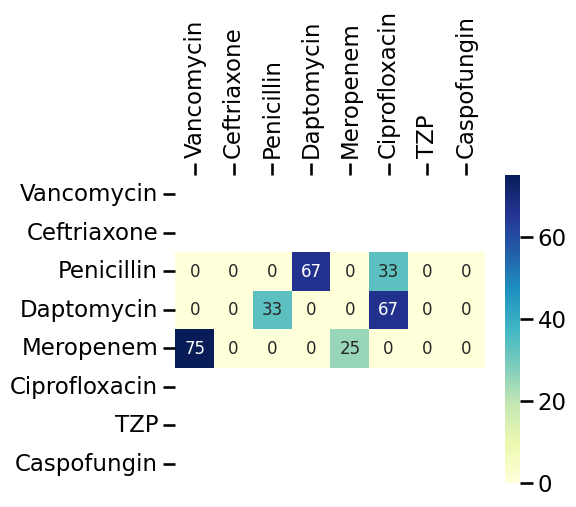

In [34]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, drop_last=True)

for X, y in train_loader:

    X = X.to(device)
    y = y.to(device)
    finetunedModel.eval()
    
    yHat = finetunedModel(X)
    
y       = y.detach().cpu().numpy()
yHat    = yHat.detach().cpu().numpy()
yHat_labels = np.argmax(yHat, axis=1)

# Mapping predictions into antibiotic groupings
y_ab = np.asarray([ATCC_GROUPINGS[i] for i in y])
y_ab_hat = np.asarray([ATCC_GROUPINGS[i] for i in yHat_labels])

# Computing accuracy
acc = (y_ab_hat == y_ab).mean()
print('Accuracy: {:0.1f}%'.format(100*acc))


sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [antibiotics[i] for i in ab_order]
cm = confusion_matrix(y_ab, y_ab_hat, labels=ab_order)
plt.figure(figsize=(5, 4))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()